In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 1, 28, 28).float() / 255.0
        self.data = 1 * (self.data > 0.5)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Wed Dec 30 14:51:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    14W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [77]:
class GatedBlock(nn.Module):
    def __init__(self, channels, v_kernel_size=(3, 5), h_kernal_size=(1, 5), causal=False):
        super().__init__()
        self.channels = channels
        self.causal = causal
        self.v_init_padding = (v_kernel_size[1]//2, v_kernel_size[1]//2, v_kernel_size[0], 0)
        self.h_init_padding = (h_kernal_size[1] - (self.causal==False), 0, 0, 0)
        self.v_conv = nn.Conv2d(channels, 2 * channels, v_kernel_size, (1, 1), (0, 0))
        self.h_conv = nn.Conv2d(channels, 2 * channels, h_kernal_size, (1, 1), (0, 0))
        self.v2h = nn.Conv2d(2 * channels, 2 * channels, (1, 1), (1, 1), (0, 0))
        self.hout = nn.Sequential(nn.Conv2d(channels, channels, (1, 1), (1, 1), (0, 0)), nn.LeakyReLU())

    def forward(self, v, h):
        v = self.v_conv(F.pad(v, self.v_init_padding)[:,:,:-1,:])
        h = F.pad(h, self.h_init_padding)
        if self.causal:
            h = h[:, :, :, :-1]
        h = self.h_conv(h) + self.v2h(v)
        v = torch.sigmoid(v[:, :self.channels, :, :]) * torch.sigmoid(v[:, self.channels:, :, :])
        h = torch.sigmoid(h[:, :self.channels, :, :]) * torch.sigmoid(h[:, self.channels:, :, :])
        return v, self.hout(h)

class Block(nn.Module):
    def __init__(self, channels, num_gatedres, v_kernel_size=(3, 5), h_kernal_size=(1, 5)):
        super().__init__()
        self.gatedres = nn.ModuleList([GatedBlock(channels, v_kernel_size, h_kernal_size, causal=False) for _ in range(num_gatedres)])
    
    def forward(self, v, h):
        for gr in self.gatedres:
            v_new, h_new = gr(v, h)
            v = v + v_new
            h = h + h_new
        return v, h

class UpBlock(nn.Module):
    def __init__(self, cin, cout, num_gatedres, v_kernel_size=(3, 5), h_kernal_size=(1, 5)):
        super().__init__()
        self.gatedres = nn.ModuleList([GatedBlock(cin, v_kernel_size, h_kernal_size, causal=False) for _ in range(num_gatedres)])
        # self.v_up = nn.Sequential(nn.Conv2d(cin, cout, (2, 2), (2, 2), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU()) #2x2 up-downsampling not works (maybe causality breaks when upsampling)
        # self.h_up = nn.Sequential(nn.Conv2d(cin, cout, (2, 2), (2, 2), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        self.v_up = nn.Sequential(nn.Conv2d(cin, cout, (1, 1), (1, 1), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        self.h_up = nn.Sequential(nn.Conv2d(cin, cout, (1, 1), (1, 1), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
    
    def forward(self, v, h):
        for gr in self.gatedres:
            v_new, h_new = gr(v, h)
            v = v + v_new
            h = h + h_new
        return self.v_up(v), self.h_up(h)



class DownBlock(nn.Module):
    def __init__(self, cin, cout, num_gatedres, v_kernel_size=(3, 5), h_kernal_size=(1, 5)):
        super().__init__()
        # self.v_down = nn.Sequential(nn.ConvTranspose2d(cin, cout, (2, 2), (2, 2), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        # self.h_down = nn.Sequential(nn.ConvTranspose2d(cin, cout, (2, 2), (2, 2), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        self.v_down = nn.Sequential(nn.ConvTranspose2d(cin, cout, (1, 1), (1, 1), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        self.h_down = nn.Sequential(nn.ConvTranspose2d(cin, cout, (1, 1), (1, 1), (0, 0)), nn.BatchNorm2d(cout), nn.LeakyReLU())
        self.gatedres = nn.ModuleList([GatedBlock(cout, v_kernel_size, h_kernal_size, causal=False) for _ in range(num_gatedres)])
    
    def forward(self, v, h):
        v = self.v_down(v)
        h = self.h_down(h)
        for gr in self.gatedres:
            v_new, h_new = gr(v, h)
            v = v + v_new
            h = h + h_new
        return v, h


class pixelcnn_plusplus(nn.Module):
    def __init__(self):
        super().__init__()
        self.fromRGB = nn.Sequential(nn.Conv2d(1, 32, (1, 1), (1, 1), (0, 0)), nn.ReLU())
        self.causal_conv = GatedBlock(32, v_kernel_size=(2, 3), h_kernal_size=(1, 3), causal=True)
        self.up = nn.ModuleList([
            UpBlock(cin=32, cout=64, num_gatedres=3, v_kernel_size=(2, 3), h_kernal_size=(1, 3)),
            UpBlock(cin=64, cout=128, num_gatedres=3, v_kernel_size=(2, 3), h_kernal_size=(1, 3))
        ])
        self.down = nn.ModuleList([
            DownBlock(cin=128, cout=32, num_gatedres=3, v_kernel_size=(2, 3), h_kernal_size=(1, 3)),
            DownBlock(cin=128, cout=64, num_gatedres=3, v_kernel_size=(2, 3), h_kernal_size=(1, 3))
        ])
        self.down_end = Block(channels=64, num_gatedres=3, v_kernel_size=(2, 3), h_kernal_size=(1, 3))
        self.toRGB = nn.Sequential(nn.Conv2d(64, 32, (1, 1), (1, 1), (0, 0)), nn.ReLU(), nn.Conv2d(32, 1, (1, 1), (1, 1), (0, 0)), nn.Sigmoid())
    
    def forward(self, x):
        x = self.fromRGB(x)
        v1, h1 = self.causal_conv(x, x)
        v2, h2 = self.up[0](v1, h1)
        v3, h3 = self.up[1](v2, h2)
        
        v_2, h_2 = self.down[1](v3, h3)
        v_1, h_1 = self.down[0](torch.cat([v2, v_2], dim=1), torch.cat([h2, h_2], dim=1))
        v_0, h_0 = self.down_end(torch.cat([v1, v_1], dim=1), torch.cat([h1, h_1], dim=1))
        x = self.toRGB(v_0 + h_0)
        return x

In [78]:
mbsz = 32
model = pixelcnn_plusplus().to(device)
solver = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [79]:
num_epochs = 5
NLL = []
for epoch in range(num_epochs):
    NLL.append(0.0)
    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device).float()
        x_p = model(x_q)
        loss = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784.
        loss.backward()
        solver.step()
        NLL[-1] += loss.item()
    NLL[-1] /= len(loader)
    print(epoch, NLL[-1]/784.)

0 0.10260401095435732
1 0.09181979233877999
2 0.08922688280222368
3 0.08698727710749826
4 0.08564457509566327


In [80]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data.float() / 255.0
testdataset = 1 * (testdataset > 0.5)

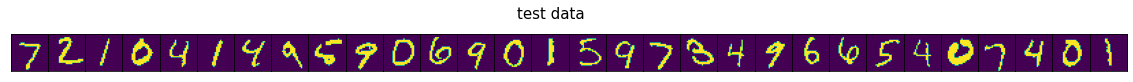

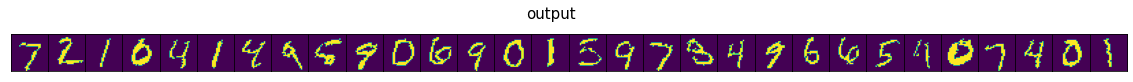

_


<Figure size 1440x144 with 0 Axes>

In [81]:
num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 1, 28, 28).float().to(device)
    x_p = model(x_q)
    x_p = 1 * (x_p > 0.5)
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')

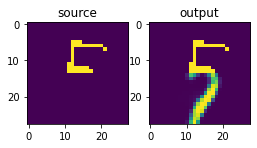

_


In [91]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[45].reshape(1, 1, 28, 28).float()
input[0, 0, 14:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(14, 28):
        for w in range(28):
            x_p = model(x_q)
            # x_q[0][0][h][w] = 1.0 * (x_p[0][0][h][w] > 0.5) 
            x_q[0][0][h][w] = x_p[0][0][h][w] 



model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')

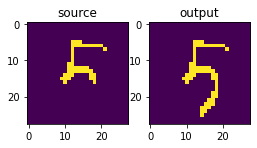

_


In [92]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[45].reshape(1, 1, 28, 28).float()
input[0, 0, 17:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(17, 28):
        for w in range(28):
            x_p = model(x_q)
            x_q[0][0][h][w] = 1.0 * (x_p[0][0][h][w] > 0.5)


model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')

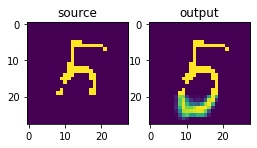

_


In [94]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[45].reshape(1, 1, 28, 28).float()
input[0, 0, 20:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(20, 28):
        for w in range(28):
            x_p = model(x_q)
            x_q[0][0][h][w] = x_p[0][0][h][w]


model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')